In [5]:
# Importing Relevant Packages
import os
import re
import csv
import time
import math
import json
import random
import unicodedata
import warnings
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Optional
from statistics import stdev
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.sat.python import cp_model
from fpdf import FPDF
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import minimize
warnings.filterwarnings("ignore")

In [7]:
# Forming the Data Structures
@dataclass
class Patient: # Forming the structure for the patients dataset
    id: int # Unique patient identifier
    name: str # Anonymised patient label
    age: int # Age of patient in years
    gender: str # Gender of patient
    admission_day: int # Day the patient was admitted in the hospital
    release_day: int # Day the patient was released from the hospital
    prefered_capacity: int # How many number of beds it is preffered the room to have
    specialism_id1: int # ID of the first required specialism 
    specialism_days_1: int # Number of days a patient requires the first specialism 
    specialism_id2: Optional[int] # ID of the second required specialism (not always there)
    specialism_days_2: Optional[int] # Number of days a patient requires the second specialism (not always there)
    needs: List[int] # ID of features the patient needs       
    prefers: List[int]  # ID of features the patient prefers


@dataclass
class Room: # Forming the structure for the room dataset
    id: int # Unique room identifier
    room_number: int  # Room number in hospital
    department: int # ID of the department the room belongs
    capacity: int # How many beds the room has
    gender: str # Gender the room is designated for
    has: List[int]  # Equipment the room has           
    spec_ids: List[int]  # IDs of the specialisms supported by this room       
    penalties: List[int] # Penalties of specialisms

In [9]:
def build_hospital_data(): # Constructing Room and Patient objects based on the structures created
    rooms_df = pd.read_csv("cleaned_rooms9.csv") # Load cleaned room CSV 
    patients_df = pd.read_csv("cleaned_patients9.csv") # Load cleaned patients CSV

    # Constructing Room objects based on the structures created
    rooms = []
    for i, row in rooms_df.iterrows():
        equipment = [] # Collecting equipment fields dynamically
        for col in ["Telemetry", "Oxygen", "Nitrogen", "Television"]:
            if col in row and not pd.isna(row[col]):
                equipment.append(int(row[col]))

        room = Room( # Creating Room instances with the following fields
            id=i,
            room_number=int(row["RoomNumber"]),
            department=int(row["DepartmentID"]),
            capacity=int(row["Capacity"]),
            gender=row["Gender"],
            has=equipment,
            spec_ids=[
                int(row["ReqSpecialism1"]),
                int(row["ReqSpecialism2"]),
                int(row["ReqSpecialism3"])
            ],
            penalties=[
                int(row["PenaltySpecialism1"]),
                int(row["PenaltySpecialism2"]),
                int(row["PenaltySpecialism3"])
            ]
        )
        rooms.append(room)

    # Constructing Patient objects based on the structures created
    patients = []
    for i, row in patients_df.iterrows():
        needs = [] # Collecting needed equipment fields dynamically
        for col in ["NeedsTelemetry", "NeedsOxygen", "NeedsNitrogen", "NeedsTV"]:
            if col in row and not pd.isna(row[col]):
                needs.append(int(row[col]))

        prefers = [] # Collecting preffered equipment fields dynamically
        for col in ["PrefersTelemetry", "PrefersOxygen", "PrefersNitrogen", "PrefersTV"]:
            if col in row and not pd.isna(row[col]):
                prefers.append(int(row[col]))

        patient = Patient( # Creating Patient instances with the following fields
            id=i,
            name=row["Name"],
            age=int(row["Age"]),
            gender=row["Gender"],
            admission_day=int(row["AdmissionDay"]),
            release_day=int(row["ReleaseDay"]),
            prefered_capacity=int(row["PreferredRoomCapacity"]),
            specialism_id1=int(row["SpecialismID1"]) if not pd.isna(row["SpecialismID1"]) else None,
            specialism_days_1=int(row["SpecialismDays1"]) if not pd.isna(row["SpecialismDays1"]) else None,
            specialism_id2=int(row["SpecialismID2"]) if not pd.isna(row["SpecialismID2"]) else None,
            specialism_days_2=int(row["SpecialismDays2"]) if not pd.isna(row["SpecialismDays2"]) else None,
            needs=needs,
            prefers=prefers
        )
        patients.append(patient)

    return rooms, patients # Returns a tuple with two lists: one list for patient attributes and the other for room attributes


In [11]:
# Extract Department Age limits from the txt file
def parse_department_ages(filepath):
    department_age_limits = {}
    with open(filepath, 'r') as file: # All the lines of the file are read
        lines = file.readlines()
    dept_section_found = False
    for line in lines:
        line = line.strip()
        if line.startswith("DEPARTMENTS:"): # Look for the section starting with DEPARTMENTS
            dept_section_found = True
            continue

        if dept_section_found: 
            if not line or line.endswith(":"):  # Stop if a line or a new section is found: end of departmen section
                break

            parts = line.split()
            if len(parts) >= 4:
                try:
                    dept_id = int(parts[0]) # Fisrt is the ID of the department
                    # Second part is a label and in this case it is ignored
                    min_age = int(parts[2]) # Third is minimum age the department supports
                    max_age = int(parts[3]) # Fourth is maximum age the department supports
                    department_age_limits[dept_id] = (min_age, max_age)
                except ValueError:
                    continue  

    return department_age_limits # Returns a tuple of the age limits


In [13]:
# Normalisation to ASCII for PDF compatibility
def clean_text(text):
    # Convert input to string if it is not already
    if not isinstance(text, str):
        text = str(text)
    # Normalize and encode
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")


# Generate a stuctured report including all the assignments over the planning horizon and patients and room characteristics
def generate_detailed_assignment_pdf(all_assignments, rooms, patients, benchmark_name="Benchmark", filename="hospital_assignment_report.pdf"):
    # Different equipment types
    equipment_labels = ['telemetry', 'oxygen', 'nitrogen', 'television']
    # Lookup dictionaries
    patient_lookup = {p.id: p for p in patients}
    room_lookup = {r.id: r for r in rooms}

    # Define a PDF class
    class PDF(FPDF):
        # Header
        def header(self):
            self.set_font("Arial", "B", 14) # Font
            # Title
            self.cell(0, 10, clean_text(f"Hospital Room Assignment Report — {benchmark_name}"), ln=True, align="C")
            self.ln(5) 

        # Title for each day
        def day_title(self, day, num_patients):
            self.set_font("Arial", "B", 12) # Font
            # Day title
            self.cell(0, 10, clean_text(f"Day {day} — Present Patients: {num_patients}"), ln=True)
            self.ln(3) 

        # Title for each room
        def room_title(self, room, patient_list):
            self.set_font("Arial", "B", 11) # Font
            # Room details
            self.cell(0, 8, clean_text(f"Room {room.id} (Capacity: {room.capacity}, Dept: {room.department}, Gender: {room.gender})"), ln=True)
            self.set_font("Arial", "", 10) 

            # Check for missing equipment
            equipment_counts = {}
            for p in patient_list:
                for i in range(min(len(p.needs), len(room.has), len(equipment_labels))):
                    if p.needs[i] == 1 and room.has[i] == 0:
                        # Count missing equipment type
                        equipment_counts[i] = equipment_counts.get(i, 0) + 1

            if equipment_counts: # Print message for missing equipment
                missing_str = "; ".join(f"{equipment_labels[i]} (needed by {count})" for i, count in equipment_counts.items())
                self.multi_cell(0, 7, clean_text(f"[MISSING] Equipment: {missing_str}")) 
            else: # If all equipment is available
                self.multi_cell(0, 7, "[OK] All required equipment covered for assigned patients.") 
            self.ln(2) 

        # Add patient details and score
        def patient_line(self, p, r, penalty):
            self.set_font("Arial", "", 10) # Font 

            # Patient specialisms
            specs = f"{p.specialism_id1}"
            if p.specialism_id2:
                specs += f", {p.specialism_id2}"

            # Patient preferences, needs, room equipment, and missing equipment
            equipment_pref = [equipment_labels[i] for i in range(min(len(p.prefers), len(equipment_labels))) if p.prefers[i] == 1]
            equipment_need = [equipment_labels[i] for i in range(min(len(p.needs), len(equipment_labels))) if p.needs[i] == 1]
            equipment_present = [equipment_labels[i] for i in range(min(len(r.has), len(equipment_labels))) if r.has[i] == 1]
            missing = [equipment_labels[i]
                       for i in range(min(len(p.needs), len(r.has), len(equipment_labels)))
                       if p.needs[i] == 1 and r.has[i] == 0]

            # Patient details line
            line = (
                f"Patient {p.id} (Age: {p.age}, Gender: {p.gender}, Specs: {specs}, "
                f"Pref: {', '.join(equipment_pref) or 'None'}, "
                f"Needs: {', '.join(equipment_need) or 'None'}, "
                f"RoomEq: {', '.join(equipment_present) or 'None'}, "
                f"Missing: {', '.join(missing) or 'None'}, "
                f"Penalty: {penalty:.2f})"
            )
            self.multi_cell(0, 7, clean_text(line))
            self.ln(1) 

    # Create PDF object
    pdf = PDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page() # Add first page

    # Iterate through assignments for the day
    for day, data in all_assignments.items():
        assignments = data['assignments'] # Assignments for the day
        scores = {v['patient_id']: v['total_score'] for v in data['violation_scores']} # Violation scores
        patient_ids = list(assignments.keys()) # Patient IDs
        present = [patient_lookup[pid] for pid in patient_ids] # Patient objects

        # Grouped patients by room
        room_groups = {}
        for pid, rid in assignments.items():
            room_groups.setdefault(rid, []).append(patient_lookup[pid]) 

        pdf.day_title(day, len(present)) # Day title

        # Add room and patient details
        for rid, patient_list in sorted(room_groups.items()):
            r = room_lookup[rid] # Room object
            pdf.room_title(r, patient_list) # Room title
            for p in patient_list:
                score = scores.get(p.id, 0) # Penalty score for the patient
                pdf.patient_line(p, r, score) # Patient details 

    # Save the PDF file
    pdf.output(filename, 'F')

In [15]:
# Compute Gini Coefficient 
def compute_gini(x):
    x = np.array(x) # Non-negative values
    if np.all(x == 0):  # If everyone has zero, then it is perfect equitablity
        return 0.0
    diff_sum = np.sum(np.abs(np.subtract.outer(x, x))) # Or else pairwise normalised absolute differences are computed
    return diff_sum / (2 * len(x) * np.sum(x))

# Jain's Index is computed
def compute_jain(x):
    x = np.array(x) # Array with non-negative values
    if np.sum(x) == 0: 
        return 1.0 # If everyone has zero, then it is perfect equitablity
    return (np.sum(x)**2) / (len(x) * np.sum(x**2)) # Or else this is returned

In [17]:
# Concatenate all experiment to a single CSV
final_df = pd.concat([
    pd.read_csv("experiment_A.csv"),
    pd.read_csv("experiment_B.csv"),
    pd.read_csv("experiment_C.csv"),
    pd.read_csv("experiment_D.csv")
], ignore_index=True)

# Save as CSV file
final_df.to_csv("rsm_all_experiments.csv", index=False)

# Confirmation message
print("Combined all experiments into rsm_all_experiments.csv")

Combined all experiments into rsm_all_experiments.csv


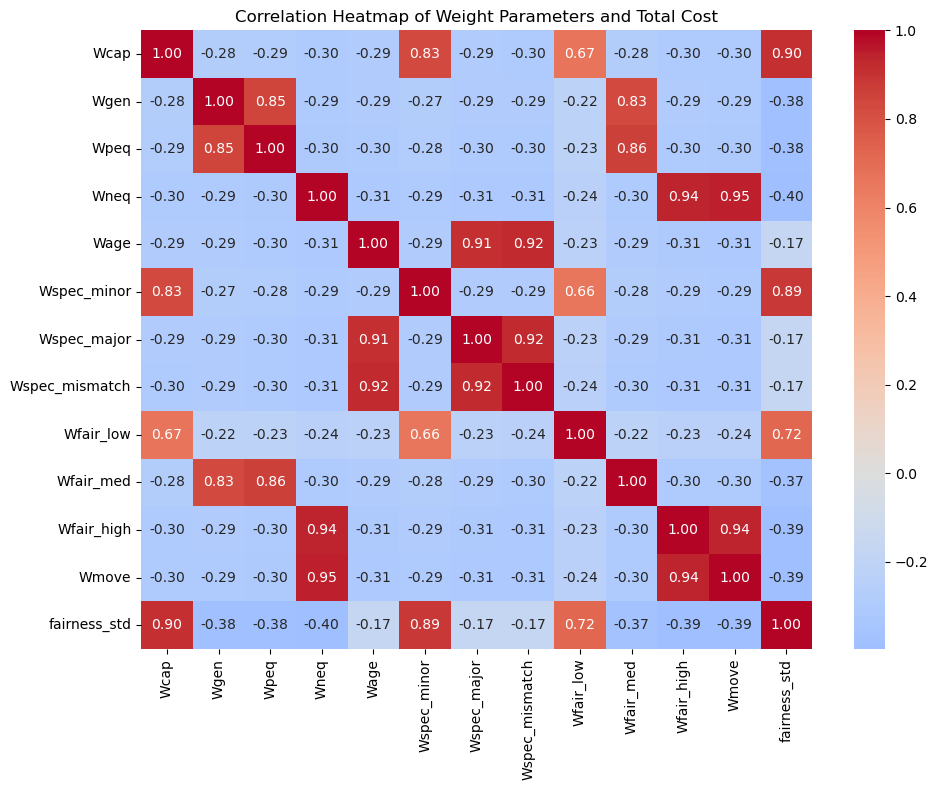

In [19]:
# Load the concentrated experiments dataset
df = pd.read_csv("rsm_all_experiments.csv")

# Weight parameters.
weight_columns = [
    'Wcap', 'Wgen', 'Wpeq', 'Wneq', 'Wage',
    'Wspec_minor', 'Wspec_major', 'Wspec_mismatch',
    'Wfair_low', 'Wfair_med', 'Wfair_high', 'Wmove'
]
# Define target variable
target_column = 'fairness_std'

# New DataFrame only with weight columns and the target variable
df_selected = df[weight_columns + [target_column]]

# Calculate pairwise correlation
corr = df_selected.corr()

plt.figure(figsize=(10, 8))
# Generate a heatmap to visualize correlation
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
# Details of the heatmap plot
plt.title("Correlation Heatmap of Weight Parameters and Total Cost")
plt.tight_layout()
# Save plot
plt.savefig("correlation_heatmap_weights_total_cost.png", dpi=300)  # Save the plot
# Display
plt.show()

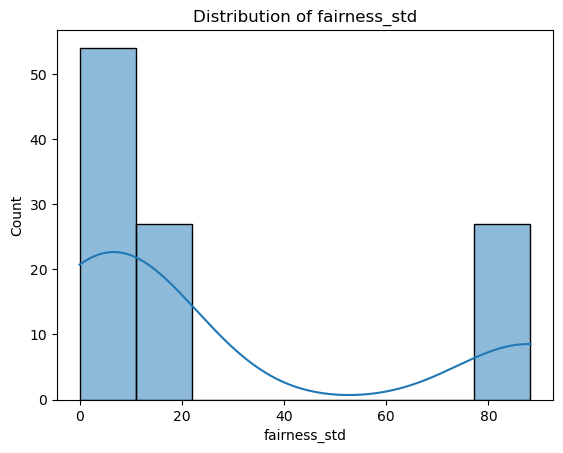

In [21]:
# Create a histogram to view std distribution
sns.histplot(df['fairness_std'], kde=True)
plt.title("Distribution of fairness_std")
# Display the plot
plt.show()

In [23]:
# Loading the experiment data
df = pd.read_csv("rsm_all_experiments.csv") 
df = df[df['status'] == 'feasible'] # Filter out infeasible results

# Outlier Removal
threshold = df['fairness_std'].quantile(0.95) # Calculate 95th percentile
df_filtered = df[df['fairness_std'] <= threshold].copy() # Filter our top 5%

# Define parameters
weight_cols = [ 
    'Wcap', 'Wgen', 'Wpeq', 'Wneq', 'Wage',
    'Wspec_minor', 'Wspec_major', 'Wspec_mismatch',
    'Wfair_low', 'Wfair_med', 'Wfair_high', 'Wmove'
]
X = df_filtered[weight_cols] 
# Define log-transformed target variable
y = np.log1p(df_filtered['fairness_std']) 

# Split into Test and Training sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 # 80% training, 20% testing
)

# linear regression model
model = LinearRegression() # Initializing
model.fit(X_train, y_train) # Train the model (training data)

# Predictions 
y_train_pred = model.predict(X_train) # Predictions on training data
y_test_pred = model.predict(X_test) # Predictions on testing data

# Calculate adjusted R squared
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Calculate R squared and adjusted R squared
train_r2 = r2_score(y_train, y_train_pred) # R squared for training data
test_r2 = r2_score(y_test, y_test_pred) # R squared for testing data
adj_r2 = adjusted_r2(train_r2, X_train.shape[0], X_train.shape[1]) # Adjusted R squared

print("\n=== Linear Regression Summary (log-transformed target) ===") # Summary
print(f"Intercept: {model.intercept_:.4f}") # Intercept of the model
print("\nCoefficients:") # Print coefficients
for name, coef in zip(weight_cols, model.coef_):
    print(f"{name:15s}: {coef:.4f}") 

print("\nModel Performance (log scale):") # Model performance metrics
print(f"Train R²:         {train_r2:.4f}") # Training R-squared
print(f"Adjusted R²:      {adj_r2:.4f}") # Adjusted R-squared
print(f"Test R²:          {test_r2:.4f}") # Testing R-squared
print(f"Train MSE:        {mean_squared_error(y_train, y_train_pred):.4f}") # Mean Squared Error (training data)
print(f"Test MSE:         {mean_squared_error(y_test, y_test_pred):.4f}") # Mean Squared Error (testing data)

# Find optimal combination of weights that minimize predicted fairness_std
def predict_fairness(weights):
    weights_df = pd.DataFrame([weights], columns=weight_cols)
    pred_log = model.predict(weights_df)[0] # Predict log-transformed fairness_std
    pred = np.expm1(pred_log)  # Convert back
    return max(pred, 0.0)  # Ensure that is non-negative

# Objective for optimization 
def objective(w):
    return predict_fairness(w) # Minimize the predicted fairness_std

# Define the bounds
bounds = [(0, 15) for _ in weight_cols]
initial_weights = np.ones(len(weight_cols))

# Run the optimization
result = minimize(objective, initial_weights, bounds=bounds)
optimal_weights = result.x # Extract optimal weights 
min_fairness_std = result.fun # Extract minimum value of objective

print("\n=== Optimized Weights to Minimize Predicted Fairness Std ===") # Print optimal weights
for name, val in zip(weight_cols, optimal_weights):
    print(f"{name:15s}: {val:.4f}") 
print(f"\nPredicted minimum fairness_std (back-transformed): {min_fairness_std:.4f}") # Print the predicted minimum fairness_std


=== Linear Regression Summary (log-transformed target) ===
Intercept: 2.8795

Coefficients:
Wcap           : 0.1806
Wgen           : -0.5028
Wpeq           : -0.1271
Wneq           : -0.1712
Wage           : -0.0002
Wspec_minor    : 0.3300
Wspec_major    : -0.0001
Wspec_mismatch : -0.0003
Wfair_low      : 0.1762
Wfair_med      : 0.1949
Wfair_high     : -0.0650
Wmove          : 0.0256

Model Performance (log scale):
Train R²:         0.9450
Adjusted R²:      0.9356
Test R²:          0.9506
Train MSE:        0.1234
Test MSE:         0.1154

=== Optimized Weights to Minimize Predicted Fairness Std ===
Wcap           : 0.0000
Wgen           : 10.3243
Wpeq           : 3.3562
Wneq           : 4.1758
Wage           : 1.0031
Wspec_minor    : 0.0000
Wspec_major    : 1.0018
Wspec_mismatch : 1.0049
Wfair_low      : 0.0000
Wfair_med      : 0.0000
Wfair_high     : 2.2058
Wmove          : 0.5257

Predicted minimum fairness_std (back-transformed): 0.0000


In [25]:
# Compatibility penalty of allocating a patient to a room
def compatibility_penalty(p, r, department_age_limits=None):
    pen = 0 # Initializing penalty to 0

    # Preferred room capacity 
    if r.capacity > p.prefered_capacity:
        pen += 0.0 # Add penalty

    # Gender mismatch 
    if r.gender in ['F', 'M'] and r.gender != p.gender:
        pen += 10.3243 # Add penalty

    # Preferred equipment unmet 
    equip_len = min(len(p.prefers), len(r.has)) 
    if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(equip_len)):
        pen += 3.3562 # Add penalty

    # Needed equipment unmet 
    need_len = min(len(p.needs), len(r.has)) 
    if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(need_len)):
        pen += 4.1758 # Add penalty

    # Department age limits 
    if department_age_limits: # If department age limits are available
        min_age, max_age = department_age_limits.get(r.department, (0, 0)) # Get age limits
        if (min_age and p.age < min_age) or (max_age and p.age > max_age): 
            pen += 1.0031 # Add penalty

    # Specialism 1
    if p.specialism_id1 is not None: 
        if p.specialism_id1 in r.spec_ids: 
            idx = r.spec_ids.index(p.specialism_id1) 
            penalty_level = r.penalties[idx] # Get penalty level associated with this specialism 
            if penalty_level == 2:
                pen += 0.0  # Add penalty
            elif penalty_level >= 3:
                pen += 1.0018  # Add penalty
        else:
            pen += 1.0049  # Add penalty

    # Specialism 2
    if p.specialism_id2 is not None: # If there is a second specialism
        if p.specialism_id2 in r.spec_ids: 
            idx = r.spec_ids.index(p.specialism_id2) 
            penalty_level = r.penalties[idx] # Get penalty level associated with this specialism
            if penalty_level == 2:
                pen += 0.0  # Add penalty
            elif penalty_level >= 3:
                pen += 1.0018  # Add penalty
        else:
            pen += 1.0049  # Add penalty

    return pen # Return total penalty for this allocation

Solving day 0...
Day 0 (initial) thresholds - Low: 4.18, High: 8.54
Day 0 solved in 0.42s — OPTIMAL
Solving day 1...
Day 1 thresholds - Low: 4.18, High: 8.54
Day 1 solved in 0.75s — OPTIMAL
Solving day 2...
Day 2 thresholds - Low: 3.36, High: 8.54
Day 2 solved in 1.22s — OPTIMAL
Solving day 3...
Day 3 thresholds - Low: 4.18, High: 8.54
Day 3 solved in 2.55s — OPTIMAL
Solving day 4...
Day 4 thresholds - Low: 4.36, High: 9.04
Day 4 solved in 3.88s — OPTIMAL
Solving day 5...
Day 5 thresholds - Low: 5.04, High: 10.32
Day 5 solved in 4.55s — OPTIMAL
Solving day 6...
Day 6 thresholds - Low: 4.97, High: 10.63
Day 6 solved in 4.25s — OPTIMAL
Solving day 7...
Day 7 thresholds - Low: 4.36, High: 10.32
Day 7 solved in 5.46s — OPTIMAL
Solving day 8...
Day 8 thresholds - Low: 4.98, High: 10.34
Day 8 solved in 6.09s — OPTIMAL
Solving day 9...
Day 9 thresholds - Low: 5.18, High: 10.32
Day 9 solved in 6.58s — OPTIMAL
Solving day 10...
Day 10 thresholds - Low: 5.65, High: 10.87
Day 10 solved in 5.64s —

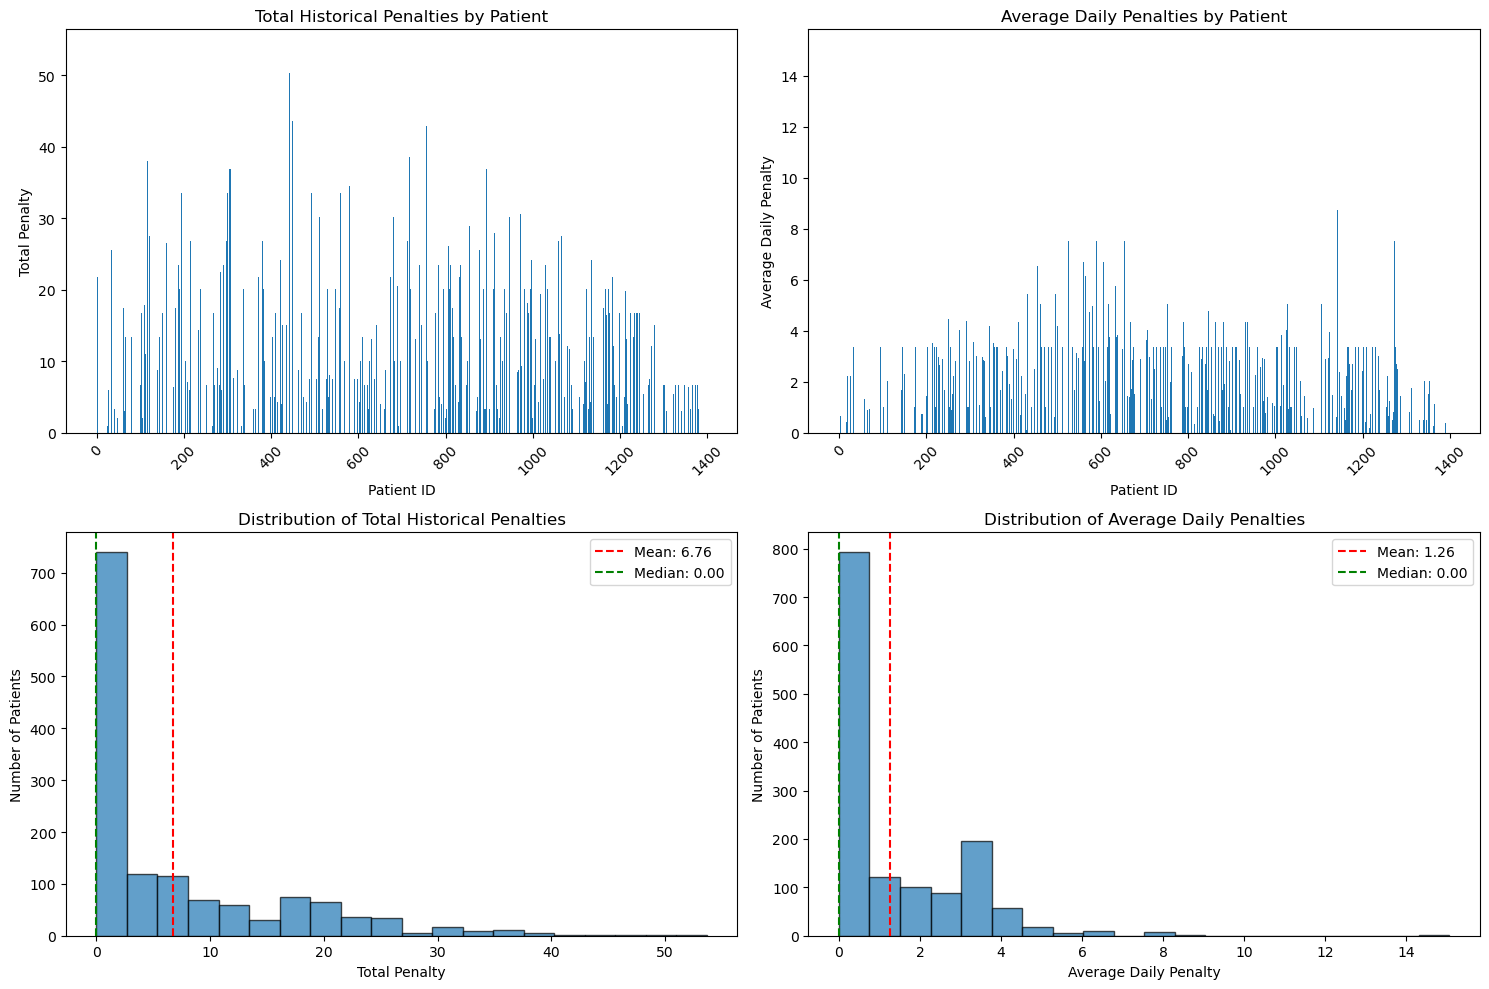

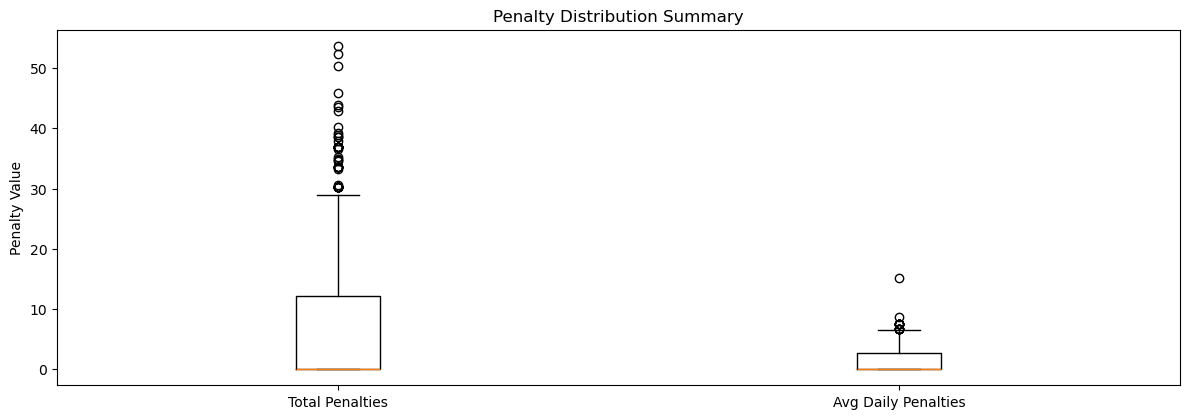

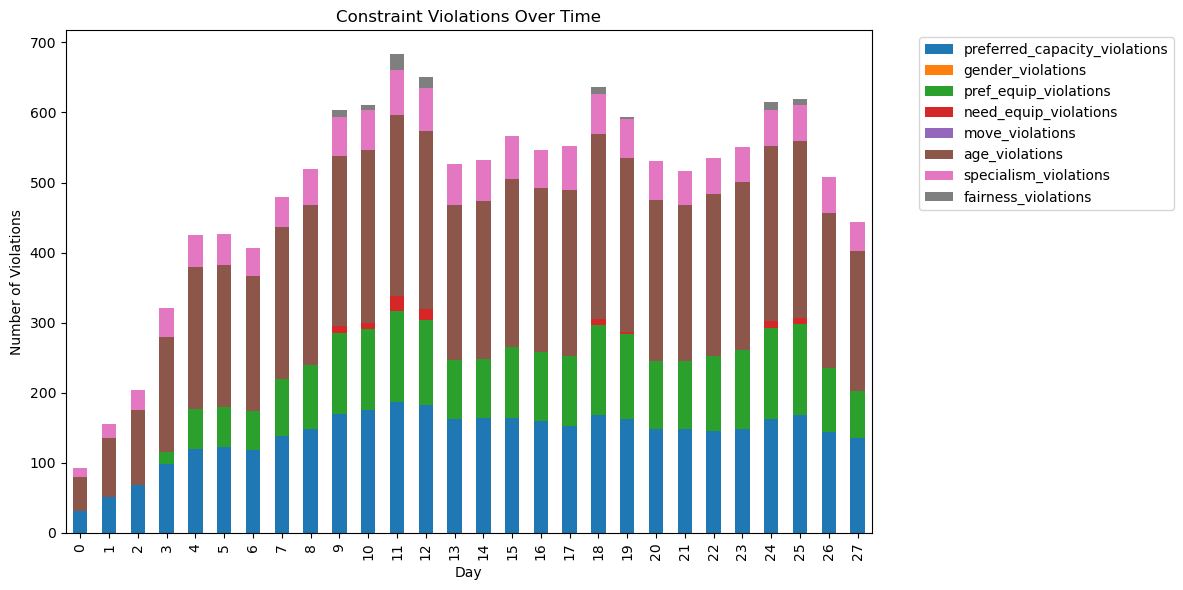

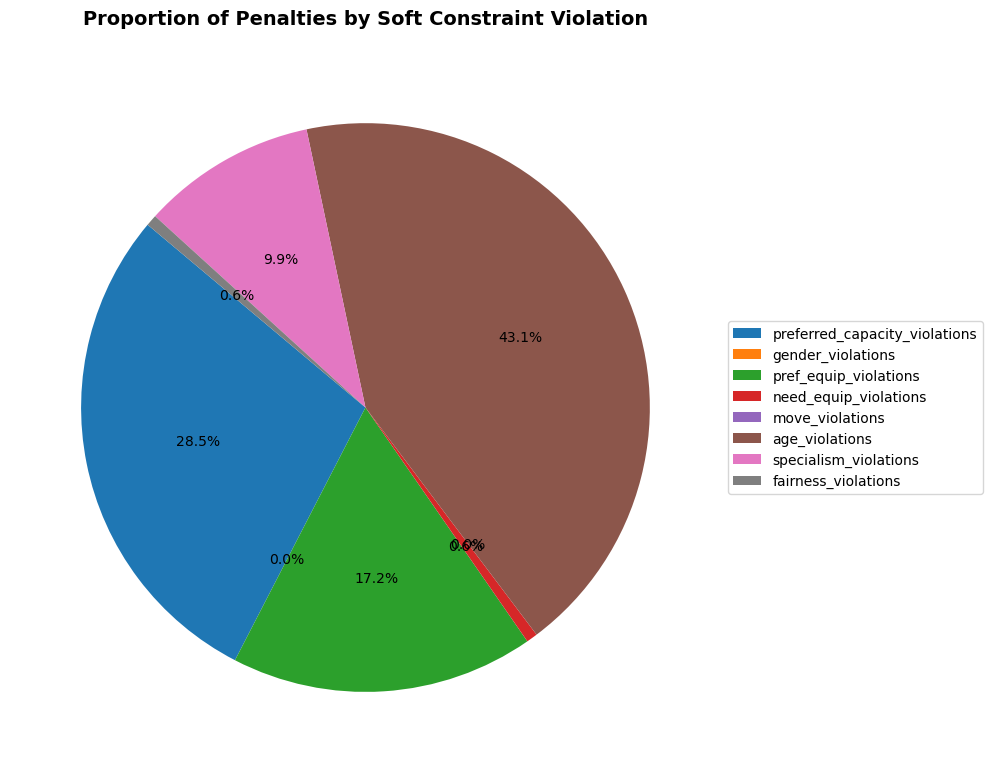

In [27]:
# Main function to solve the allocation
def solve_hospital_allocation():
    # Build hospital data 
    rooms, patients = build_hospital_data()
    # Random seed for reproducibility
    random.seed(42)
    # Get department age limits for this dataset from txt file
    department_age_limits = parse_department_ages("test9.txt")

    total_duration = 0.0 # Initialize total solving time
    historical_penalties = {p.id: 0 for p in patients} # Initialize historical penalties to zero
    previous_assignments = {} # Dictionary for previous room assignments
    daily_assignment_penalties = {} # Dictionary for assignments penalties

    # Determine the planning horizon
    last_admission_day = max(p.admission_day for p in patients)
    all_days = range(last_admission_day + 1)
    logs = {} # Store logs 
    all_assignments = {} # Dictionary for all assignments made each day
    results = [] # Store summary results

    # Solving day by day 
    for current_day in all_days:
        print(f"Solving day {current_day}...")
        objective_vals = [] # Store total penalty
        time_stamps = [] # Store timestamps 
        prev_penalties = daily_assignment_penalties.get(current_day - 1, {}) # Penalties from previous assignment 
        max_prev_penalty = max(prev_penalties.values(), default=None) # Maximum penalty from previous assignment

        # Uncertain admissions
        for p in patients:

            # Delayed admission 
            if p.admission_day == current_day:
                if random.random() < 0.3: # 30% chance of delay by 1 or 2 days
                    delay = random.randint(1, 2) 
                    duration = p.release_day - p.admission_day 
                    p.admission_day += delay # Update admission day
                    p.release_day = p.admission_day + duration # Update release day 

                    # Record delay
                    if not hasattr(p, "arrival_delays"):
                        p.arrival_delays = []
                    p.arrival_delays.append({
                        "day": current_day,
                        "delay": delay,
                        "new_admission": p.admission_day,
                        "new_release": p.release_day,
                    })

            # Early admission 
            if p.admission_day == current_day:
                if random.random() < 0.3: # 30% chance of early admission by 1 or 2 days
                    advance = random.randint(1, 2) 
                    duration = p.release_day - p.admission_day 
                    p.admission_day = max(0, p.admission_day - advance) # Update admission day
                    p.release_day = p.admission_day + duration # Update release day 

                    # Record early arrival
                    if not hasattr(p, "early_arrivals"):
                        p.early_arrivals = []
                    p.early_arrivals.append({
                        "day": current_day,
                        "advance": advance,
                        "new_admission": p.admission_day,
                        "new_release": p.release_day,
                    })

            # Late release 
            if p.release_day == current_day:
                if random.random() < 0.3: # 30% chance of late release by 1 or 2 days
                    extension = random.randint(1, 2) 
                    p.release_day += extension # Update release day

                    # Record late release
                    if not hasattr(p, "late_releases"):
                        p.late_releases = []
                    p.late_releases.append({
                        "day": current_day,
                        "extension": extension,
                        "new_release": p.release_day,
                    })

            # Early release
            if p.release_day == current_day:
                if random.random() < 0.3: # 30% chance of early release by 1 or 2 days
                    reduction = random.randint(1, 2) 
                    new_release = max(p.admission_day + 1, p.release_day - reduction) # Update new release day
                    if new_release < p.release_day:
                        # Record early release
                        if not hasattr(p, "early_releases"):
                            p.early_releases = []
                        p.early_releases.append({
                            "day": current_day,
                            "early_by": p.release_day - new_release, 
                            "new_release": new_release, 
                        })
                        p.release_day = new_release 

        # Identify present patients
        present_patients = [p for p in patients if p.admission_day <= current_day < p.release_day]
        # Skip if there are no present patients
        if not present_patients:
            continue

        # Threshold calculation 
        if current_day > 0:
            all_fairness_scores = []
            for p in present_patients:
                for r in rooms:
                    base_pen = compatibility_penalty(p, r) # Compatibility penalty
                    # Calculate normalised historical penalties bias
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1)
                    fairness_score = base_pen * bias # Fairness score 
                    all_fairness_scores.append(fairness_score)

            scores_array = np.array(all_fairness_scores)
            threshold_low = np.percentile(scores_array, 33) # Calculate lower fairness threshold, 33rd percentile
            threshold_high = np.percentile(scores_array, 67) # Calculate higher fairness threshold, 67th percentile

            print(f"Day {current_day} thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")
        else: # For the first day
            # Only base compatibility scores
            all_base_scores = []
            for p in present_patients:
                for r in rooms:
                    base_pen = compatibility_penalty(p, r) 
                    all_base_scores.append(base_pen)

            scores_array = np.array(all_base_scores) # Convert scores to a numpy array
            # Calculate the lower and upper thresholds based on percentiles of base scores
            threshold_low = np.percentile(scores_array, 33) # Calculate lower fairness threshold, 33rd percentile
            threshold_high = np.percentile(scores_array, 67) # Calculate higher fairness threshold, 67th percentile

            print(f"Day {current_day} (initial) thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")

        # Model Definition
        model = cp_model.CpModel() 
        seats = {} # Decision Variable
        # Boolean variable for each possible assignment
        for r in rooms:
            for p in present_patients:
                seats[(r.id, p.id)] = model.NewBoolVar(f"s_r{r.id}_p{p.id}_d{current_day}")

        # Hard Constraints
        # Assigned to exactly one room
        for p in present_patients:
            model.Add(sum(seats[(r.id, p.id)] for r in rooms) == 1)

        # Room capacity must not be exceeded
        for r in rooms:
            model.Add(sum(seats[(r.id, p.id)] for p in present_patients) <= r.capacity)

        # Equipment types 
        num_equipment_types = min(
            max(len(r.has) for r in rooms), 
            max(len(p.needs) for p in present_patients) 
        )

        # Patients that need specific equipment must be assigned to rooms with that equipment
        for i in range(num_equipment_types):
            rooms_with_equipment = [r for r in rooms if len(r.has) > i and r.has[i] == 1]
            total_available = len(rooms_with_equipment) # Number of rooms with the equipment

            patients_with_need = [p for p in present_patients if len(p.needs) > i and p.needs[i] == 1]
            total_needed = len(patients_with_need) # Number of patients needing the equipment

            # Only enforce if availability is sufficient
            if total_available >= len(patients_with_need):
                for p in patients_with_need:
                    assign_with_eq = [seats[(r.id, p.id)] for r in rooms_with_equipment]
                    model.AddBoolOr(assign_with_eq)

        # Soft Constraints
        viol_pref_cap = [] # List for Preferred capacity violations
        viol_gender = [] # List for Gender violations
        viol_pref_eq = [] # List for Preferred equipment violations
        viol_need_eq = [] # List for Needed equipment violations
        viol_age = [] # List for Age limit violations
        viol_spec_minor = [] # List for Minor specialism violations
        viol_spec_major = [] # List for Major specialism violations
        viol_spec_mismatch = [] # List for Specialism mismatch violations
        viol_fairness_low = [] # List for Fairness violations (below low threshold) 
        viol_fairness_medium = [] # List for Fairness violations (between low and high thresholds)
        viol_fairness_high = [] # List for Fairness violations (above high threshold)
        move_penalties = [] # List for Move Penalties 

        # Get violations for each allocation
        for p in present_patients:
            prev_room = previous_assignments.get(p.id) # Get previous assignment
            for r in rooms:
                s = seats[(r.id, p.id)] # Assigning patient p to room r

                # Preferred capacity violation
                if r.capacity > p.prefered_capacity:
                    viol_pref_cap.append(s) # Add penalty

                # Gender violation
                if r.gender in ('M','F') and r.gender != p.gender:
                    viol_gender.append(s) # Add penalty

                # Preferred equipment violation
                equip_len = min(len(p.prefers), len(r.has))
                # Check if any preferred equipment is missing in the room
                if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(equip_len)):
                    viol_pref_eq.append(s) # Add penalty

                # Needed equipment violation
                equip_need_len = min(len(p.needs), len(r.has))
                # Check if any needed equipment is missing in the room
                if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(equip_need_len)):
                    viol_need_eq.append(s) # Add penalty

                # Age Constraint
                min_age, max_age = department_age_limits.get(r.department, (0, 0)) # Get age limits from txt file
                # Check if the patient's age violates the department's age limits
                if (min_age and p.age < min_age) or (max_age and p.age > max_age):
                    viol_age.append(s) # Add penalty

                # Specialism 1 Violations 
                if p.specialism_id1 in r.spec_ids: 
                    idx = r.spec_ids.index(p.specialism_id1) 
                    pen = r.penalties[idx] # Get associated penalty
                    if pen == 2: 
                        viol_spec_minor.append(s) # Add penalty
                    elif pen >= 3: 
                        viol_spec_major.append(s) # Add penalty
                else:
                    viol_spec_mismatch.append(s) # Add penalty

                # Sppecialism 2 Violations
                if p.specialism_id2 is not None: # Check if there is a second specialism
                    if p.specialism_id2 in r.spec_ids: 
                        idx = r.spec_ids.index(p.specialism_id2) 
                        pen = r.penalties[idx] # Get associated penalty
                        if pen == 2: 
                            viol_spec_minor.append(s) # Add penalty
                        elif pen >= 3: 
                            viol_spec_major.append(s) # Add penalty
                    else:
                        viol_spec_mismatch.append(s) # Add penalty

                # Fairness Violations
                base_pen = compatibility_penalty(p, r) # Compatibility penalty
                if current_day > 0: 
                    # Calculate normalised historical penalties bias
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1)
                    fairness_score = base_pen * bias # Fairness score
                else: # For the first day
                    fairness_score = base_pen # Compatibility penalty
                # Check if is above thresholds
                if fairness_score > threshold_high:
                    viol_fairness_high.append(s) # Add penalty
                elif fairness_score > threshold_low:
                    viol_fairness_medium.append(s) # Add penalty
                elif fairness_score < threshold_low:
                    viol_fairness_low.append(s) # Add penalty

                # Move Penalty
                if prev_room is not None and r.id != prev_room:
                    move_penalties.append(s) # Add penalty

        # Objective Function
        # Normalisation by possible allocations number
        normalizer = len(present_patients) * len(rooms)
        def normalized_sum(viol_list):
            return sum(viol_list) * (1.0 / max(1, normalizer)) 

        # Optimised weights for soft constraints 
        Wcap, Wgen, Wpeq, Wneq, Wage = 0, 10.3243, 3.3562, 4.178, 1.0031
        Wspec_minor, Wspec_major, Wspec_mismatch = 0, 1.0018, 1.0049
        Wfair_low, Wfair_med, Wfair_high = 0, 0, 2.2058
        Wmove = 0.5257

        # Minimize total cost
        model.Minimize(
              Wcap * normalized_sum(viol_pref_cap) # Preferred capacity violations
            + Wgen * normalized_sum(viol_gender) # Gender violations
            + Wpeq * normalized_sum(viol_pref_eq) # Preferred equipment violations
            + Wneq * normalized_sum(viol_need_eq) # Needed equipment violations
            + Wage * normalized_sum(viol_age) # Aage limit violations
            + Wspec_minor * normalized_sum(viol_spec_minor) # Minor specialism violations
            + Wspec_major * normalized_sum(viol_spec_major) # Major specialism violations
            + Wspec_mismatch * normalized_sum(viol_spec_mismatch) # Specialism mismatch violations
            + Wfair_low * normalized_sum(viol_fairness_low) # Low fairness violations 
            + Wfair_med * normalized_sum(viol_fairness_medium) # Medium fairness violations 
            + Wfair_high * normalized_sum(viol_fairness_high) # High fairness violations
            + Wmove * normalized_sum(move_penalties) # Move penalties
        )

        # Solving the Model 
        solver = cp_model.CpSolver() 
        start = time.time() # Start time 
        status = solver.Solve(model) 
        day_duration = time.time() - start # Calculate the time taken 
        total_duration += day_duration # Total Duration

        # Solving status and time 
        print(f"Day {current_day} solved in {day_duration:.2f}s — {solver.StatusName(status)}")

        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            assign = {} # Dictionary for room assignment 
            violation_scores = [] # List for detailed violation scores 
            daily_score = 0 # Initialize the total violation score for the day

            # Iterate through all present patients and rooms to calculate penalties
            for p in present_patients:
                assigned_room = None # Initialize
                for r in rooms:
                    if solver.Value(seats[(r.id, p.id)]): 
                        assigned_room = r 
                        assign[p.id] = r.id # Record the room ID in the assignments dictionary
                        previous_assignments[p.id] = r.id # Update the previous assignment 
                        break 

                # If a room was assigned to the patient
                if assigned_room:
                    # Calculate the total compatibility penalty for this assignment
                    pen = compatibility_penalty(p, assigned_room, department_age_limits) 
                    daily_score += pen # Add to the total score
                    historical_penalties[p.id] += pen  # Update the historical penalty 

                    equipment_labels = ['telemetry', 'oxygen', 'nitrogen', 'television']
                    max_equipment_index = min(len(p.needs), len(assigned_room.has), len(equipment_labels))
                    missing_eq = [
                        i for i in range(max_equipment_index)
                        if p.needs[i] == 1 and assigned_room.has[i] == 0
                    ]
                    equip_len = min(len(p.prefers), len(assigned_room.has))
                    need_len = min(len(p.needs), len(assigned_room.has))

                    # Specialism Violations 
                    spec_minor = 0 
                    spec_major = 0 
                    spec_mismatch = 0 

                    # Specialism 1 violations
                    if p.specialism_id1 is not None: 
                        if p.specialism_id1 in assigned_room.spec_ids: 
                            idx = assigned_room.spec_ids.index(p.specialism_id1) 
                            spec_pen = assigned_room.penalties[idx] # Get associated penalty
                            if spec_pen == 2:
                                spec_minor += 1 # Minor violation count
                            elif spec_pen >= 3:
                                spec_major += 1 # Major violation count
                        else:
                            spec_mismatch += 1 # Mismatch violation count

                    # Specialism 2 violations
                    if p.specialism_id2 is not None: # If the patient has a second specialism
                        if p.specialism_id2 in assigned_room.spec_ids: 
                            idx = assigned_room.spec_ids.index(p.specialism_id2) 
                            spec_pen = assigned_room.penalties[idx] # Get associated penalty
                            if spec_pen == 2:
                                spec_minor += 1 # Minor violation count
                            elif spec_pen >= 3:
                                spec_major += 1 # Major violation count
                        else:
                            spec_mismatch += 1 # Mismatch violation count

                    # Violation scores for a patient
                    violation_scores.append({
                        'patient_id': p.id,
                        'room_id': assigned_room.id,
                        'total_score': pen, # Total compatibility penalty 
                        'historical_penalty': historical_penalties[p.id], # Cumulative historical penalty for the patient
                        'violations': {
                            'capacity': int(assigned_room.capacity > p.prefered_capacity), 
                            'gender': int(assigned_room.gender in ['F', 'M'] and assigned_room.gender != p.gender), 
                            'equipment_pref': int(any(p.prefers[i] == 1 and assigned_room.has[i] == 0 for i in range(equip_len))), 
                            'equipment_need': int(any(p.needs[i] == 1 and assigned_room.has[i] == 0 for i in range(need_len))), 
                            'age':int((min_age and p.age < min_age) or (max_age and p.age > max_age)), 
                            'specialism_minor': spec_minor, 
                            'specialism_major': spec_major, 
                            'specialism_mismatch': spec_mismatch, 
                            'moved': int(previous_assignments.get(p.id) is not None and assigned_room.id != previous_assignments.get(p.id))
                        }
                    })

            # Storing Assignments and violation scores for the current day for future use
            all_assignments[current_day] = {
                'assignments': assign, 
                'violation_scores': violation_scores 
            }

            # Number of move violations for the day 
            move_count = sum(v['violations']['moved'] for v in violation_scores)

            # Results for the current day added to the results list
            results.append({
                'day': current_day, # Current day
                'num_patients': len(present_patients), # Number of present patients
                # Count total violations for each type across all assigned patients on this day
                'preferred_capacity_violations': sum(v['violations']['capacity'] for v in violation_scores),
                'gender_violations': sum(v['violations']['gender'] for v in violation_scores),
                'pref_equip_violations': sum(v['violations']['equipment_pref'] for v in violation_scores),
                'need_equip_violations': sum(v['violations']['equipment_need'] for v in violation_scores),
                'age_violations': sum(v['violations']['age'] for v in violation_scores),
                'specialism_violations': sum( 
                    v['violations']['specialism_minor'] +
                    v['violations']['specialism_major'] +
                    v['violations']['specialism_mismatch']
                    for v in violation_scores
                ),
                'move_violations': sum(v['violations']['moved'] for v in violation_scores), 
                'fairness_violations': sum(1 for v in violation_scores if v['total_score']  > threshold_low),
                'total_violation_score': daily_score, # Total compatibility penalty 
                'threshold_low': threshold_low, # Low fairness threshold
                'threshold_high': threshold_high # High fairness threshold 
            })

    # Final metrics
    if results: # Check if there are results
        df = pd.DataFrame(results) # Create a DataFrame for results
        total_days = len(all_days) # Total number of days
        # Success rate
        success_rate = len(results) / total_days * 100
        patient_ids = list(historical_penalties.keys())
        # Length of stay
        stay_length = {p.id: max(1, p.release_day - p.admission_day) for p in patients}
        # Average daily penalty
        avg_daily_penalty = {pid: historical_penalties[pid]/stay_length[pid] for pid in stay_length}
        # List of all average daily penalties
        penalty_vals = list(avg_daily_penalty.values())

        # Calculate fairness metrics 
        std_dev = np.std(penalty_vals) # Standard deviation
        gini = compute_gini(penalty_vals) # Gini coefficient
        jain = compute_jain(penalty_vals) # Jain's fairness index

        # Mean of the average daily penalties
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids]
        # Find maximum and minimum
        max_penalty_idx = np.argmax(penalty_vals)
        min_penalty_idx = np.argmin(penalty_vals)

        # Calculate the total number of fairness violations across all days
        total_fairness_penalties = df['fairness_violations'].sum()
        print(f"Total Fairness Penalties: {total_fairness_penalties}")

        # Summary statistics
        summary_stats = {
            "Metric": [
                "Total Solving Time (s)", # Total time 
                "Success Rate (%)", # Percentage of feasible or optimal solution
                "Fairness - StdDev of Daily Penalty", # Standard deviation 
                "Fairness - Gini Coefficient", # Gini coefficient 
                "Fairness - Jain Index", # Jain's fairness index 
                "Total Penalty - Mean", # Mean of total historical penalties
                "Total Penalty - StdDev", # Standard deviation of total historical penalties
                "Total Penalty - Min", # Minimum total historical penalty
                "Total Penalty - Max", # Maximum total historical penalty
                "Avg Daily Penalty - Mean", # Mean of average daily penalties
                "Avg Daily Penalty - StdDev", # Standard deviation of average daily penalties
                "Avg Daily Penalty - Min", # Minimum average daily penalty
                "Avg Daily Penalty - Max", # Maximum average daily penalty
                "Patients with Zero Penalty", # Number of 0 penalty patients 
                "Patients with High Penalty (>mean+std)", # Number of high penalty patients
                f"Most Penalized Patient (ID {patient_ids[max_penalty_idx]})", # Most penalized patient
                f"Least Penalized Patient (ID {patient_ids[min_penalty_idx]})", # Least penalized patient
            ],
            "Value": [
                f"{total_duration:.2f}", # Total duration
                f"{success_rate:.2f}", # Success rate
                f"{std_dev:.2f}", # Standard deviation
                f"{gini:.2f}", # Gini coefficient
                f"{jain:.2f}", # Jain index
                f"{np.mean(penalty_vals):.2f}", # Mean total penalty
                f"{np.std(penalty_vals):.2f}", # Standard deviation of total penalty
                f"{np.min(penalty_vals):.2f}", # Minimum total penalty
                f"{np.max(penalty_vals):.2f}", # Maximum total penalty
                f"{np.mean(avg_penalties):.2f}", # Mean average daily penalty
                f"{np.std(avg_penalties):.2f}", # Standard deviation of average daily penalty
                f"{np.min(avg_penalties):.2f}", # Minimum average daily penalty
                f"{np.max(avg_penalties):.2f}", # Maximum average daily penalty
                f"{sum(1 for p in penalty_vals if p == 0)}", # Patients with zero penalty
                f"{sum(1 for p in penalty_vals if p > np.mean(penalty_vals) + np.std(penalty_vals))}", # Highly penalized patients
                f"Total: {penalty_vals[max_penalty_idx]:.2f}, Avg: {avg_penalties[max_penalty_idx]:.2f}", # Penalties for most penalized patient
                f"Total: {penalty_vals[min_penalty_idx]:.2f}, Avg: {avg_penalties[min_penalty_idx]:.2f}", # Penalties for least penalized patient
            ]
        }

        # DataFrame for summary statistics
        summary_df = pd.DataFrame(summary_stats)
        # Print summary statistics 
        print("\n=== SUMMARY STATISTICS ===")
        print(summary_df.to_string(index=False)) 

        # Save summary statistics as a CSV
        summary_df.to_csv("hospital_summary_statistics3.csv", index=False)

        fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.4))
        ax.axis('off') # Turn off axes
        # Table for statistics
        table = ax.table(cellText=summary_df.values,
                         colLabels=summary_df.columns,
                         cellLoc='left', 
                         loc='center') 
        table.auto_set_font_size(False) 
        table.set_fontsize(10) 
        table.scale(1, 1.2) 
        plt.title("Hospital Allocation Summary Statistics", fontsize=14, weight='bold', pad=20) 
        plt.tight_layout() # Adjust layout
        plt.savefig("hospital_summary_statistics3.png", dpi=300) # Save as a PNG
        plt.close() 

        # PLOTS
        fig, axes = plt.subplots(2, 2, figsize=(15, 10)) 
        # Bar plot of total historical penalties 
        penalty_vals = list(historical_penalties.values()) # Total historical penalty values
        patient_ids = list(historical_penalties.keys()) 

        axes[0,0].bar(range(len(patient_ids)), penalty_vals) 
        axes[0,0].set_title('Total Historical Penalties by Patient') 
        axes[0,0].set_xlabel('Patient ID') 
        axes[0,0].set_ylabel('Total Penalty') 
        axes[0,0].tick_params(axis='x', rotation=45) 

        # Bar plot of average daily penalties
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids] # Average daily penalties

        axes[0,1].bar(range(len(patient_ids)), avg_penalties) 
        axes[0,1].set_title('Average Daily Penalties by Patient') 
        axes[0,1].set_xlabel('Patient ID')
        axes[0,1].set_ylabel('Average Daily Penalty')
        axes[0,1].tick_params(axis='x', rotation=45) 

        # Histogram of total penalties
        axes[1,0].hist(penalty_vals, bins=min(20, len(set(penalty_vals))), alpha=0.7, edgecolor='black')
        axes[1,0].set_title('Distribution of Total Historical Penalties') 
        axes[1,0].set_xlabel('Total Penalty') 
        axes[1,0].set_ylabel('Number of Patients') 
        axes[1,0].axvline(np.mean(penalty_vals), color='red', linestyle='--', label=f'Mean: {np.mean(penalty_vals):.2f}') # Line for mean
        axes[1,0].axvline(np.median(penalty_vals), color='green', linestyle='--', label=f'Median: {np.median(penalty_vals):.2f}') # Line for median
        axes[1,0].legend() # Legend

        # Histogram of average daily penalties
        axes[1,1].hist(avg_penalties, bins=min(20, len(set(avg_penalties))), alpha=0.7, edgecolor='black') 
        axes[1,1].set_title('Distribution of Average Daily Penalties') 
        axes[1,1].set_xlabel('Average Daily Penalty') 
        axes[1,1].set_ylabel('Number of Patients') 
        axes[1,1].axvline(np.mean(avg_penalties), color='red', linestyle='--', label=f'Mean: {np.mean(avg_penalties):.2f}') # Line for mean
        axes[1,1].axvline(np.median(avg_penalties), color='green', linestyle='--', label=f'Median: {np.median(avg_penalties):.2f}') # Line for median
        axes[1,1].legend() # Legend

        plt.tight_layout()
        plt.savefig("penalty_subplots_summary3.png") # Save figure
        plt.show() # Display 

        plt.figure(figsize=(12, 8)) # Create a new figure
        # Box plot for distribution of total and average daily penalties
        plt.subplot(2, 1, 1) # Create the first subplot in a 2x1 grid
        plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) 
        plt.title('Penalty Distribution Summary') 
        plt.ylabel('Penalty Value')

        plt.tight_layout() 
        plt.savefig("penalty_boxplot_summary3.png") # Save figure
        plt.show() # Display

        # Types of violations
        violation_cols = [
            'preferred_capacity_violations','gender_violations',
            'pref_equip_violations','need_equip_violations', 'move_violations',
            'age_violations','specialism_violations', 'fairness_violations'
        ]

        # Stacked bar plot, number of violations over time
        df.set_index('day')[violation_cols].plot.bar(stacked=True, figsize=(12,6))
        plt.title("Constraint Violations Over Time") 
        plt.xlabel("Day") 
        plt.ylabel("Number of Violations") 
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Legend 
        plt.tight_layout() 
        plt.savefig("constraint_violations_over_time3.png") # Save figure
        plt.show() # Display

        # Pie Chart 
        violation_totals = df[violation_cols].sum() # Sum the total violations

        plt.figure(figsize=(10, 10)) 
        patches, texts, autotexts = plt.pie(
            violation_totals, 
            labels=None, 
            autopct='%1.1f%%', 
            startangle=140
        )
        # Add a legend 
        plt.legend(patches, violation_totals.index, loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title("Proportion of Penalties by Soft Constraint Violation", fontsize=14, weight='bold', pad=20) # Set title
        plt.tight_layout()
        plt.savefig("constraint_violation_pie_chart3.png", dpi=300) # Save as PNG
        plt.show() # Display 

    # Return the collected data 
    return all_assignments, rooms, patients, results

# Execution
if __name__ == "__main__":
    # Call the main allocation function
    all_assignments, rooms, patients, results = solve_hospital_allocation()
    # Generate PDF report 
    generate_detailed_assignment_pdf(
        all_assignments,
        rooms,
        patients,
        benchmark_name="test9", # Name of the benchmark used
        filename="hospital_assignment_report3.pdf" 
    )